In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# SET RANDOM SEED
np.random.seed(0) # need for reproducibility

In [3]:
!pip install aif360
!pip install BlackBoxAuditing
!pip install fairlearn==0.4.6

# Load Data

In [4]:
from aif360.datasets import BinaryLabelDataset

In [5]:
adult_numerical = pd.read_csv('https://raw.githubusercontent.com/alaude1/fairness-mia/master/fairness/data/preprocessed/adult_numerical.csv')
filtered_idx = adult_numerical['race'] != 'Other'
adult_numerical = adult_numerical[filtered_idx]
adult_numerical['race-sex'] = adult_numerical['race-sex'].astype('category')
map_race_sex = dict( enumerate(adult_numerical['race-sex'].cat.categories))
adult_numerical['race-sex'] = adult_numerical['race-sex'].cat.codes

adult_numerical['race'] = adult_numerical['race'].astype('category')
map_race = dict( enumerate(adult_numerical['race'].cat.categories))
adult_numerical['race'] = adult_numerical['race'].cat.codes


adult_numerical['sex'] = adult_numerical['sex'].astype('category')
map_sex = dict( enumerate(adult_numerical['sex'].cat.categories))
adult_numerical['sex'] = adult_numerical['sex'].cat.codes

adult_numerical['income-per-year'] = adult_numerical['income-per-year'].astype('category')
map_income = dict( enumerate(adult_numerical['income-per-year'].cat.categories))
adult_numerical['income-per-year'] = adult_numerical['income-per-year'].cat.codes


In [6]:
adult_binary = BinaryLabelDataset(df=adult_numerical,
                                  label_names=['income-per-year'], 
                                  protected_attribute_names=['race-sex'], 
                                  instance_weights_name=None, 
                                  scores_names=[], 
                                  unprivileged_protected_attributes=[], 
                                  privileged_protected_attributes=[], 
                                  metadata=None)

In [7]:
ad_train, ad_test = adult_binary.split(2)

In [8]:
from sklearn.metrics import log_loss
def gen_gap_per_group(pred_prob_train, Y_train, attr_train, pred_prob_test, Y_test, attr_test):
    unique_attr = np.unique(attr_train)
    for a in unique_attr:
        ind_train = (attr_train == a)
        Y_train_a = Y_train[ind_train]
        pred_prob_train_a = pred_prob_train[ind_train]
        
        ind_test = (attr_test == a)
        Y_test_a = Y_test[ind_test]
        pred_prob_test_a = pred_prob_test[ind_test]
        
        gap = abs(log_loss(Y_train_a, pred_prob_train_a) - log_loss(Y_test_a, pred_prob_test_a))
        print('generalization gap for group {}: {}'.format(a, gap))

# Unconstrained Model

In [9]:
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from aif360.metrics import ClassificationMetric

In [10]:
ad_df_train, ad_attrs_train = ad_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
ad_df_test, ad_attrs_test = ad_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)

In [11]:
ad_df_train.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,race-sex,workclass_Federal-gov,workclass_Local-gov,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income-per-year
0,39.0,13.0,3.0,1.0,2174.0,0.0,40.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,50.0,13.0,3.0,1.0,0.0,0.0,13.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,38.0,9.0,3.0,1.0,0.0,0.0,40.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53.0,7.0,2.0,1.0,0.0,0.0,40.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28.0,13.0,2.0,0.0,0.0,0.0,40.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
Y_train = np.array(ad_df_train[['income-per-year']]).reshape(((len(ad_df_train),))).astype(int)
Xs_train = np.array(ad_df_train.drop(columns='income-per-year'))
Y_test = np.array(ad_df_test[['income-per-year']]).reshape(((len(ad_df_test),))).astype(int)
Xs_test = np.array(ad_df_test.drop(columns='income-per-year'))

In [13]:
clf = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_train, Y_train)

In [14]:
predicted_labels_train = clf.predict(Xs_train).reshape((len(Y_train), 1))
predicted_labels = clf.predict(Xs_test).reshape((len(Y_test), 1))

In [15]:
ad_pred = deepcopy(ad_test)
ad_pred_train = deepcopy(ad_train)
ad_pred.labels = predicted_labels
ad_pred_train.labels = predicted_labels_train

In [16]:
u = [{'race-sex': 0, 'race-sex': 1, 'race-sex': 2, 'race-sex': 3, 'race-sex': 4, 'race-sex': 5, 'race-sex': 6}]
p = [{'race-sex': 7}]
metrics = ClassificationMetric(ad_test,ad_pred,unprivileged_groups=u, privileged_groups=p)
test_acc = metrics.accuracy()
DI = metrics.disparate_impact()
EO = metrics.average_abs_odds_difference()
print('Original Test Accuracy:', test_acc)
print('Original Demographic Parity ratio:', DI)
print('Original Average Absolute Odds diff:', EO)

Original Test Accuracy: 0.8460407617774808
Original Demographic Parity ratio: 0.2996890474115724
Original Average Absolute Odds diff: 0.0921651727995266


### Membership Inference Attack

In [17]:
from mia.membership_inference_attacks import black_box_benchmarks

In [18]:
# Membership inference attack

# train shadow model
shadow_train, shadow_test = ad_test.split(2)
shadow_train_df, _ = shadow_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_test_df, _ = shadow_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_Y_train = np.array(shadow_train_df[['income-per-year']]).reshape(((len(shadow_train_df),))).astype(int)
shadow_Xs_train = np.array(shadow_train_df.drop(columns='income-per-year'))
shadow_Y_test = np.array(shadow_test_df[['income-per-year']]).reshape(((len(shadow_test_df),))).astype(int)
shadow_Xs_test = np.array(shadow_test_df.drop(columns='income-per-year'))

true_pred_on_shadow_train = clf.predict(shadow_Xs_train)
true_pred_on_shadow_test = clf.predict(shadow_Xs_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train)


In [19]:
# get outputs
shadow_out_train = shadow_model.predict_proba(shadow_Xs_train)
shadow_out_test = shadow_model.predict_proba(shadow_Xs_test)
true_model_train = clf.predict_proba(Xs_train)
true_model_test = clf.predict_proba(Xs_test)

In [20]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [21]:
shadow_train_df['race-sex'] = shadow_train_df['race'].astype(str) + '-' + shadow_train_df['sex'].astype(str)
shadow_train_df['race-sex'] = shadow_train_df['race-sex'].astype('category').cat.codes
shadow_test_df['race-sex'] = shadow_test_df['race'].astype(str) + '-' + shadow_test_df['sex'].astype(str)
shadow_test_df['race-sex'] = shadow_test_df['race-sex'].astype('category').cat.codes
ad_df_train['race-sex'] = ad_df_train['race'].astype(str) + '-' + ad_df_train['sex'].astype(str)
ad_df_train['race-sex'] = ad_df_train['race-sex'].astype('category').cat.codes
ad_df_test['race-sex'] = ad_df_test['race'].astype(str) + '-' + ad_df_test['sex'].astype(str)
ad_df_test['race-sex'] = ad_df_test['race-sex'].astype('category').cat.codes

In [22]:
shadow_attr_train = shadow_train_df['race-sex'].astype(int)
shadow_attr_test = shadow_test_df['race-sex'].astype(int)
train_attr = ad_df_train['race-sex'].astype(int)
test_attr = ad_df_test['race-sex'].astype(int)

In [23]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [24]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.537
For membership inference attack via confidence, group attr 1, the attack acc is 0.500
For membership inference attack via confidence, group attr 2, the attack acc is 0.500
For membership inference attack via confidence, group attr 3, the attack acc is 0.518
For membership inference attack via confidence, group attr 4, the attack acc is 0.501
For membership inference attack via confidence, group attr 5, the attack acc is 0.493
For membership inference attack via confidence, group attr 6, the attack acc is 0.498
For membership inference attack via confidence, group attr 7, the attack acc is 0.497
For membership inference attack via confidence, the attack acc is 0.498
For membership inference attack via entropy, group attr 0, the attack acc is 0.537
For membership inference attack via entropy

In [25]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [26]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.551
For membership inference attack via confidence, group attr 1, the attack acc is 0.581
For membership inference attack via confidence, group attr 2, the attack acc is 0.571
For membership inference attack via confidence, group attr 3, the attack acc is 0.534
For membership inference attack via confidence, group attr 4, the attack acc is 0.524
For membership inference attack via confidence, group attr 5, the attack acc is 0.518
For membership inference attack via confidence, group attr 6, the attack acc is 0.509
For membership inference attack via confidence, group attr 7, the attack acc is 0.504
For membership inference attack via confidence, the attack acc is 0.509
For membership inference attack via entropy, group attr 0, the attack acc is 0.560
For membership inference attack via entropy

In [27]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.02653179014848006
generalization gap for group 1: 0.09867048823883351
generalization gap for group 2: 0.17540731468109852
generalization gap for group 3: 0.002246638772167242
generalization gap for group 4: 0.017953527783204845
generalization gap for group 5: 0.00017322828103910615
generalization gap for group 6: 0.000798460180094579
generalization gap for group 7: 0.01122496554711061


### Privacy Risk Score Analysis

In [28]:
from mia.privacy_risk_score_utils import calculate_risk_score

In [29]:
print(map_race_sex)
print(map_race)
print(map_sex)
print(map_income)

{0: 'Amer-Indian-Eskimo-Female', 1: 'Amer-Indian-Eskimo-Male', 2: 'Asian-Pac-Islander-Female', 3: 'Asian-Pac-Islander-Male', 4: 'Black-Female', 5: 'Black-Male', 6: 'White-Female', 7: 'White-Male'}
{0: 'Amer-Indian-Eskimo', 1: 'Asian-Pac-Islander', 2: 'Black', 3: 'White'}
{0: 'Female', 1: 'Male'}
{0: '<=50K', 1: '>50K'}


In [30]:
# make a dict for risk scores
risk_scores_dict = {}

In [31]:
def risk_hist(attr_map, attr_name, ad_df_train, risk_scores, colors):
    for i, key in enumerate(attr_map):
        idx = ad_df_train[attr_name] == key
        plt.hist(risk_scores[idx], label=attr_map[key], density=True, color=colors[i], alpha=0.5)
    plt.legend()
    plt.xlabel('privacy risk score')
    plt.ylabel('frequency')
    #plt.savefig('{}.png'.format(attr_name))

In [32]:
def risk_hist_subplots(attr_map, attr_name, ad_df_train, risk_scores, ht, wdth, figsize, colors, title):
    fig, axs = plt.subplots(ht, wdth, sharey = True, sharex = True, figsize=figsize)
    for i, key in enumerate(attr_map):
        idx = ad_df_train[attr_name] == key
        if ht == 1:
            axs[i].hist(risk_scores[idx], label=attr_map[key], density=True, color=colors[i], alpha=0.5)
            axs[i].set_title(attr_map[key]) 
            axs[i].set_xlabel('Privacy Risk Score') 
            axs[i].set_ylabel('Frequency')
        else:
            axs[int(i/wdth), int(i%wdth)].hist(risk_scores[idx], label=attr_map[key], density=True, color=colors[i], alpha=0.5)
            axs[int(i/wdth), int(i%wdth)].set_title(attr_map[key])
            axs[int(i/wdth), int(i%wdth)].set_xlabel('Privacy Risk Score')
            axs[int(i/wdth), int(i%wdth)].set_ylabel('Frequency')
    for ax in axs.flatten():
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
    fig.suptitle(title, fontsize=16)

In [33]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


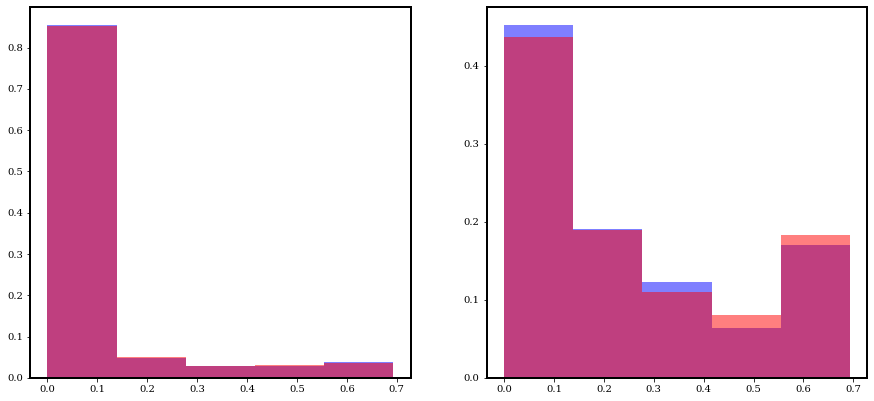

In [34]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

In [35]:
# add to dict
risk_scores_dict['unconstrained'] = risk_scores

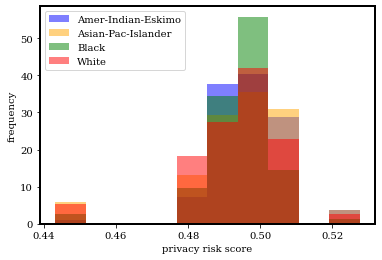

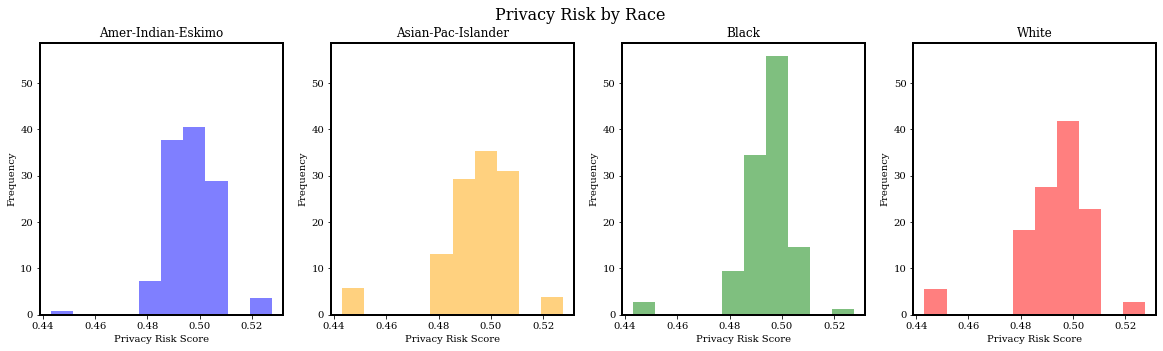

In [36]:
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race'
risk_hist(map_race, 'race', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race, 'race', ad_df_train, risk_scores, 1, 4, (20, 5), colors, title)

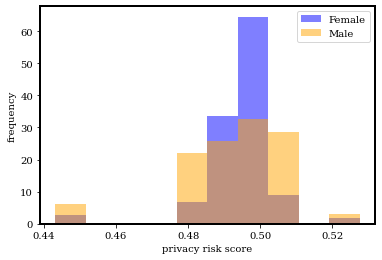

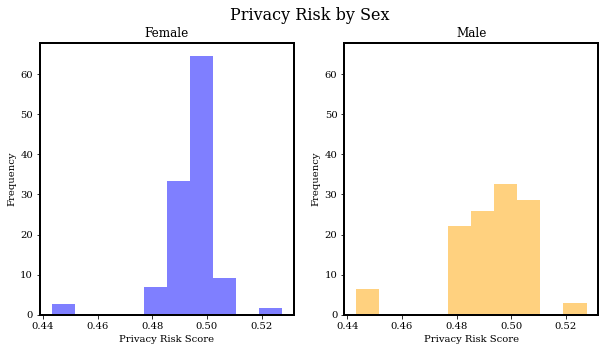

In [37]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex'
risk_hist(map_sex, 'sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_sex, 'sex', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

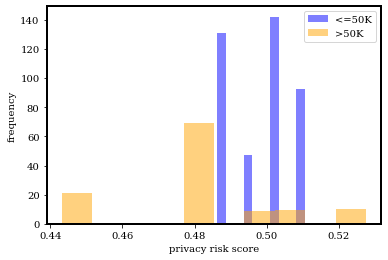

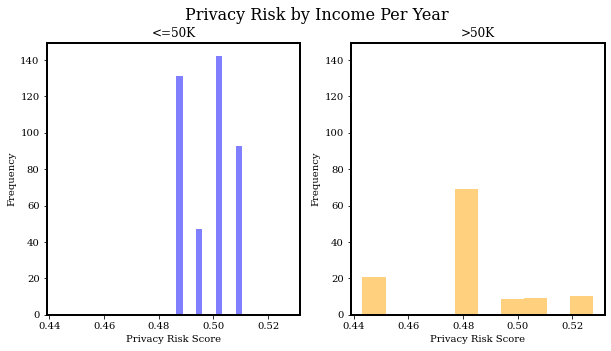

In [38]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Income Per Year'
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_income, 'income-per-year', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

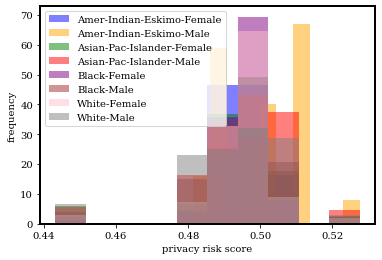

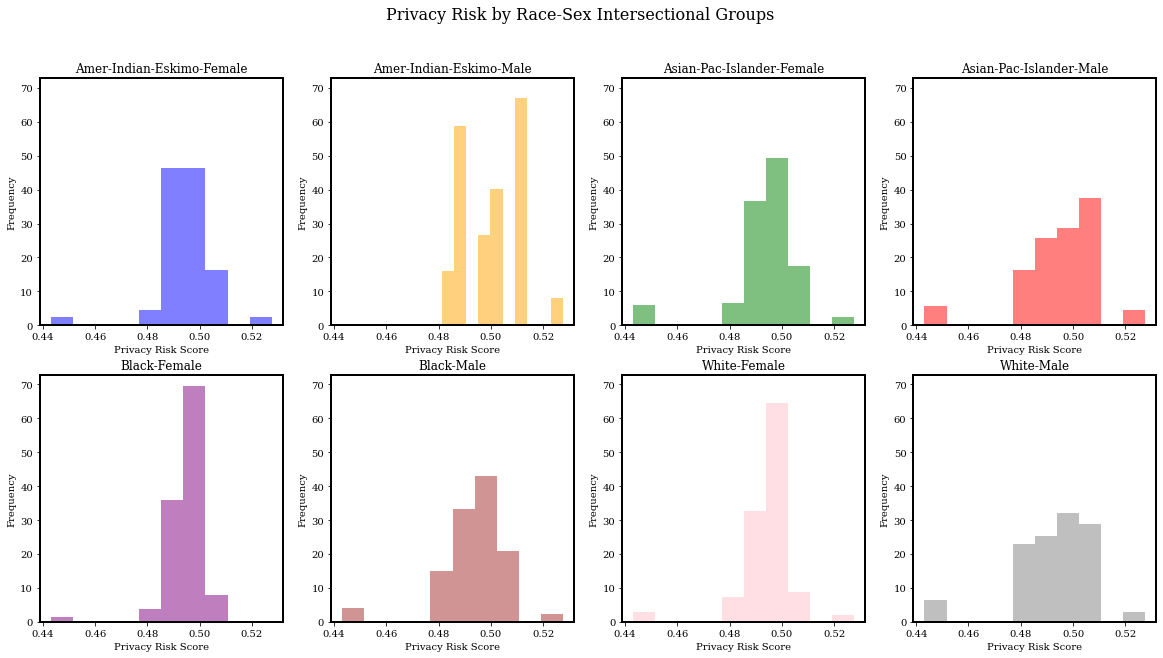

In [39]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups'
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race_sex, 'race-sex', ad_df_train, risk_scores, 2, 4, (20, 10), colors, title)

# Demographic Parity (Independence)

## Feldman et al. Repair (Preprocessing)

In [40]:
import aif360.algorithms.preprocessing as AIF

In [41]:
# tuning repair level to minimize test accuracy tradeoff
x = np.arange(0, 1.1, 0.1)
test_acc = []
dp = []
for rep in x:
    repairer = AIF.DisparateImpactRemover(repair_level=rep, sensitive_attribute='race-sex')
    repaired_train = repairer.fit_transform(ad_train)
    repaired_test = repairer.fit_transform(ad_test)
    repaired_df_train, repaired_attrs_train = repaired_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
    repaired_df_test, repaired_attrs_test = repaired_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
    Y_rep_train = np.array(repaired_df_train[['income-per-year']]).reshape(((len(repaired_df_train),)))
    Xs_rep_train = np.array(repaired_df_train.drop(columns='income-per-year'))

    Y_rep_test = np.array(repaired_df_test[['income-per-year']]).reshape(((len(repaired_df_test),)))
    Xs_rep_test = np.array(repaired_df_test.drop(columns='income-per-year'))
    clf_rep = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_rep_train, Y_rep_train)
    predicted_labels_rep = clf_rep.predict(Xs_rep_test).reshape((len(Y_rep_test), 1))
    ad_pred_rep = deepcopy(ad_test)
    ad_pred_rep.labels = predicted_labels_rep
    metrics_rep = ClassificationMetric(ad_test,ad_pred_rep,unprivileged_groups=u, privileged_groups=p)
    test_acc_rep = metrics_rep.accuracy()
    DI_rep = metrics_rep.disparate_impact()
    EO_rep = metrics_rep.average_abs_odds_difference()
    print('Repair Test Accuracy:', test_acc_rep)
    print('Repair Demographic Parity ratio:', DI_rep)
    print('Repair Average Absolute Odds diff:', EO_rep)
    test_acc.append(test_acc_rep)
    dp.append(DI_rep)

Repair Test Accuracy: 0.8460407617774808
Repair Demographic Parity ratio: 0.2996890474115724
Repair Average Absolute Odds diff: 0.0921651727995266
Repair Test Accuracy: 0.8422318743735383
Repair Demographic Parity ratio: 0.34804309366220265
Repair Average Absolute Odds diff: 0.04552405114404716
Repair Test Accuracy: 0.8321416638823923
Repair Demographic Parity ratio: 0.36680107788928323
Repair Average Absolute Odds diff: 0.021620180211741686
Repair Test Accuracy: 0.8200467758102239
Repair Demographic Parity ratio: 0.36969801923395645
Repair Average Absolute Odds diff: 0.016875117024262098
Repair Test Accuracy: 0.8279318409622453
Repair Demographic Parity ratio: 0.34792896246244465
Repair Average Absolute Odds diff: 0.02351611801217639
Repair Test Accuracy: 0.7763448045439358
Repair Demographic Parity ratio: 0.3535370930244723
Repair Average Absolute Odds diff: 0.1691238814832795
Repair Test Accuracy: 0.6379552288673571
Repair Demographic Parity ratio: 0.5389444969074306
Repair Average 

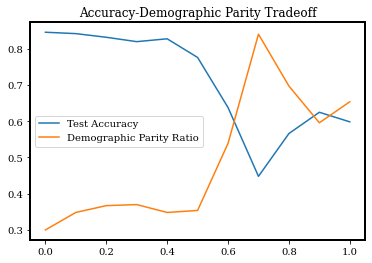

In [42]:
plt.clf()
plt.plot(x, test_acc, label='Test Accuracy')
plt.plot(x, dp, label='Demographic Parity Ratio')
plt.legend()
plt.title('Accuracy-Demographic Parity Tradeoff')
plt.savefig("feldman_repair.png")

In [43]:
# repair level 0.9 seems to have ok demographic parity ratio and with a small drop in test accuracy
repairer = AIF.DisparateImpactRemover(repair_level=0.9, sensitive_attribute='race-sex')
repaired_train = repairer.fit_transform(ad_train)
repaired_test = repairer.fit_transform(ad_test)
repaired_df_train, repaired_attrs_train = repaired_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
repaired_df_test, repaired_attrs_test = repaired_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
Y_rep_train = np.array(repaired_df_train[['income-per-year']]).reshape(((len(repaired_df_train),)))
Xs_rep_train = np.array(repaired_df_train.drop(columns='income-per-year'))

Y_rep_test = np.array(repaired_df_test[['income-per-year']]).reshape(((len(repaired_df_test),)))
Xs_rep_test = np.array(repaired_df_test.drop(columns='income-per-year'))
clf_rep = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_rep_train, Y_rep_train)
predicted_labels_rep = clf_rep.predict(Xs_rep_test).reshape((len(Y_rep_test), 1))
ad_pred_rep = deepcopy(ad_test)
ad_pred_rep.labels = predicted_labels_rep
metrics_rep = ClassificationMetric(ad_test,ad_pred_rep,unprivileged_groups=u, privileged_groups=p)
test_acc_rep = metrics_rep.accuracy()
DI_rep = metrics_rep.disparate_impact()
EO_rep = metrics_rep.average_abs_odds_difference()
print('Repair Test Accuracy:', test_acc_rep)
print('Repair Demographic Parity ratio:', DI_rep)
print('Repair Average Absolute Odds diff:', EO_rep)

Repair Test Accuracy: 0.6248580020046776
Repair Demographic Parity ratio: 0.595803148566808
Repair Average Absolute Odds diff: 0.13010211992005563


### Membership Inference Attack

In [44]:
# Membership inference attack

repaired_shadow_train = repairer.fit_transform(shadow_train)
repaired_shadow_test = repairer.fit_transform(shadow_test)

shadow_train_df, _ = repaired_shadow_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_test_df, _ = repaired_shadow_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_Xs_train = np.array(shadow_train_df.drop(columns='income-per-year'))
shadow_Xs_test = np.array(shadow_test_df.drop(columns='income-per-year'))


# train shadow model
true_pred_on_shadow_train = clf_rep.predict(shadow_Xs_train)
true_pred_on_shadow_test = clf_rep.predict(shadow_Xs_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train)

In [45]:
true_pred_on_shadow_train = true_pred_on_shadow_train.astype(int).reshape(len(true_pred_on_shadow_train),)
true_pred_on_shadow_test = true_pred_on_shadow_test.astype(int).reshape(len(true_pred_on_shadow_test),)

In [46]:
shadow_out_train = clf_rep.predict_proba(shadow_Xs_train)
shadow_out_test = clf_rep.predict_proba(shadow_Xs_test)
true_model_train = clf_rep.predict_proba(Xs_rep_train)
true_model_test = clf_rep.predict_proba(Xs_rep_test)

In [47]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [48]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [49]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.608, with train acc 0.842 and test acc 0.625
For membership inference attack via confidence, group attr 0, the attack acc is 0.675
For membership inference attack via confidence, group attr 1, the attack acc is 0.599
For membership inference attack via confidence, group attr 2, the attack acc is 0.689
For membership inference attack via confidence, group attr 3, the attack acc is 0.571
For membership inference attack via confidence, group attr 4, the attack acc is 0.704
For membership inference attack via confidence, group attr 5, the attack acc is 0.546
For membership inference attack via confidence, group attr 6, the attack acc is 0.673
For membership inference attack via confidence, group attr 7, the attack acc is 0.605
For membership inference attack via confidence, the attack acc is 0.625
For membership inference attack via entropy, group attr 0, the attack acc is 0.675
For membership inference attack via entropy

In [50]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [51]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.608, with train acc 0.842 and test acc 0.625
For membership inference attack via confidence, group attr 0, the attack acc is 0.766
For membership inference attack via confidence, group attr 1, the attack acc is 0.721
For membership inference attack via confidence, group attr 2, the attack acc is 0.784
For membership inference attack via confidence, group attr 3, the attack acc is 0.671
For membership inference attack via confidence, group attr 4, the attack acc is 0.813
For membership inference attack via confidence, group attr 5, the attack acc is 0.687
For membership inference attack via confidence, group attr 6, the attack acc is 0.757
For membership inference attack via confidence, group attr 7, the attack acc is 0.658
For membership inference attack via confidence, the attack acc is 0.695
For membership inference attack via entropy, group attr 0, the attack acc is 0.762
For membership inference attack via entropy

In [52]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.16351636543501477
generalization gap for group 1: 0.5989117683022334
generalization gap for group 2: 0.3361392965424115
generalization gap for group 3: 0.3638498939172903
generalization gap for group 4: 0.35885751318452075
generalization gap for group 5: 0.45150847337837
generalization gap for group 6: 0.4232183045504463
generalization gap for group 7: 0.4694267261502603


### Privacy Risk Score Analysis

In [53]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


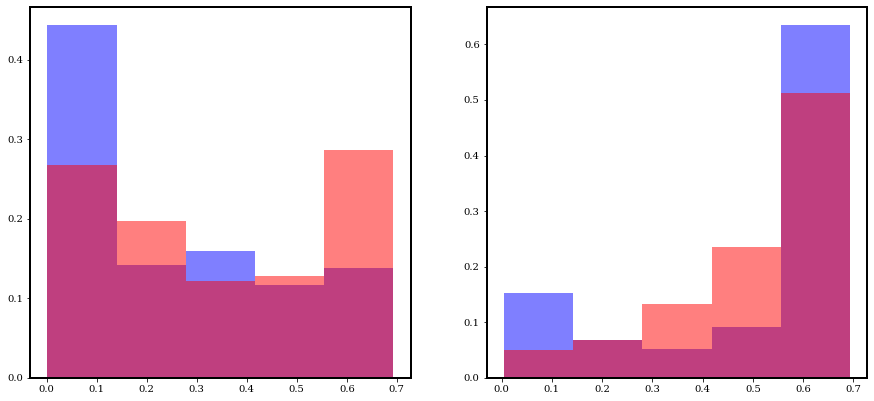

In [54]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

In [55]:
# add to dict
risk_scores_dict['feldman'] = risk_scores

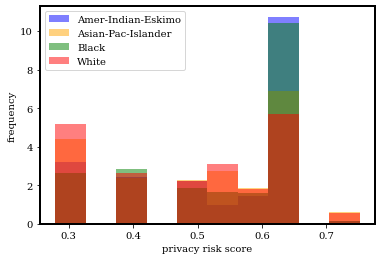

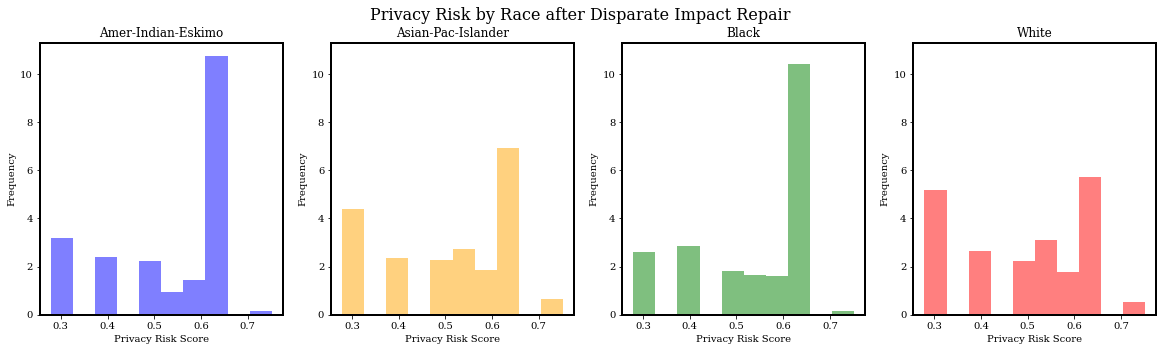

In [56]:
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race after Disparate Impact Repair'
risk_hist(map_race, 'race', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race, 'race', ad_df_train, risk_scores, 1, 4, (20, 5), colors, title)

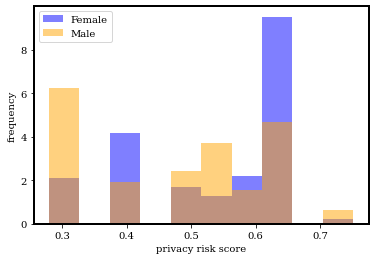

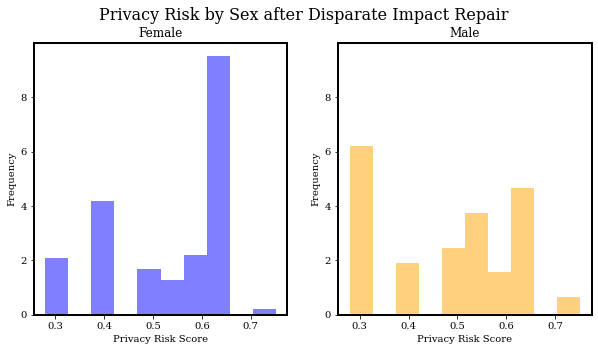

In [57]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex after Disparate Impact Repair'
risk_hist(map_sex, 'sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_sex, 'sex', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

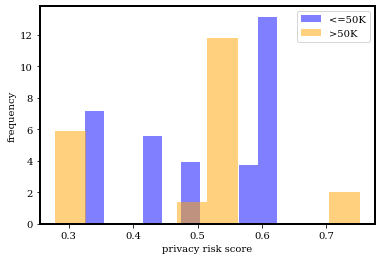

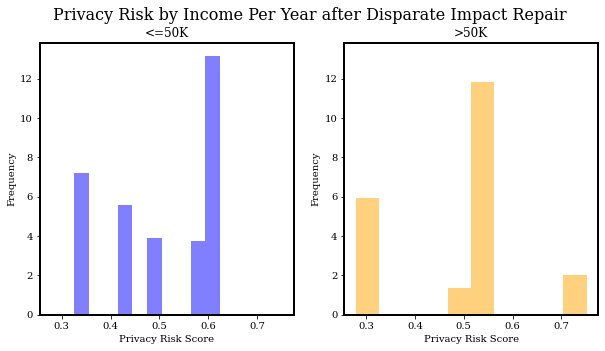

In [58]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Income Per Year after Disparate Impact Repair'
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_income, 'income-per-year', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

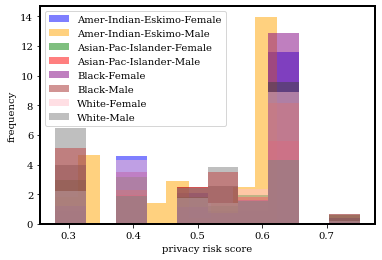

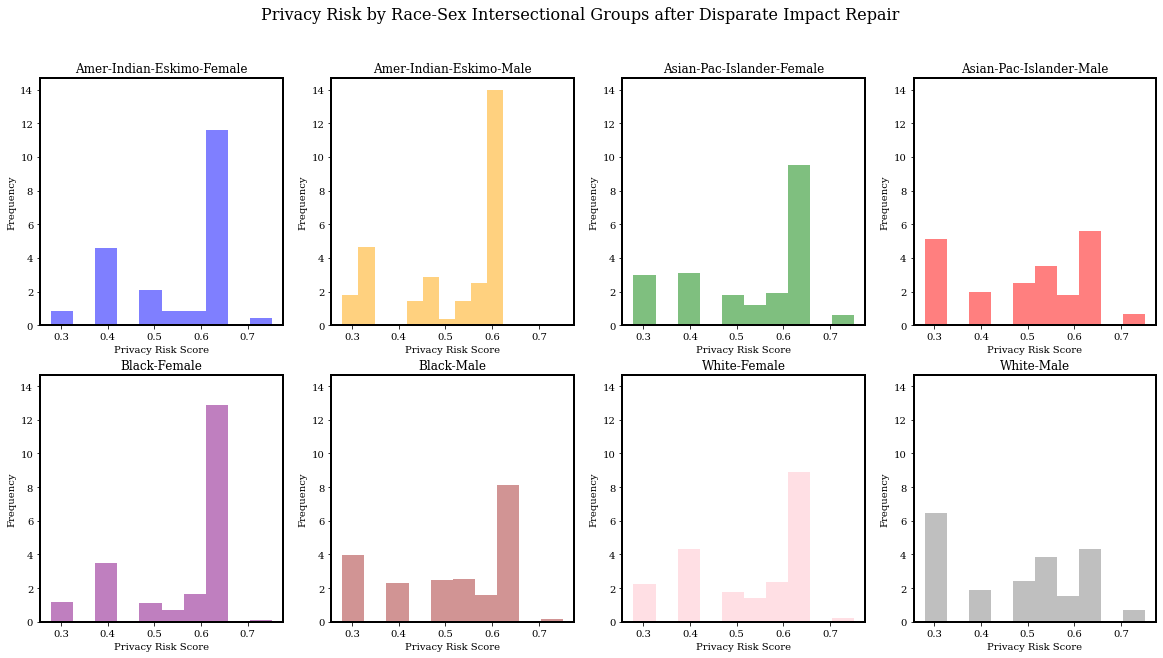

In [59]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups after Disparate Impact Repair'
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race_sex, 'race-sex', ad_df_train, risk_scores, 2, 4, (20, 10), colors, title)

## Agarwal et al (Reduction)

In [60]:
from aif360.algorithms.inprocessing.exponentiated_gradient_reduction import ExponentiatedGradientReduction

In [61]:
estimator = LogisticRegression(solver='liblinear')
#np.random.seed(0) 
#need for reproducibility
exp_grad_red_dp = ExponentiatedGradientReduction(estimator=estimator, 
                                              constraints="DemographicParity",
                                              drop_prot_attr=False)

In [62]:
exp_grad_red_dp.fit(ad_train)
exp_grad_red_pred_dp = exp_grad_red_dp.predict(ad_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [63]:
metrics_red_dp = ClassificationMetric(ad_test,exp_grad_red_pred_dp,unprivileged_groups=u, privileged_groups=p)
test_acc_red_dp = metrics_red_dp.accuracy()
DI_red_dp = metrics_red_dp.disparate_impact()
EO_red_dp = metrics_red_dp.average_abs_odds_difference()
print('DP Reduction Test Accuracy:', test_acc_red_dp)
print('DP Reduction Demographic Parity ratio:', DI_red_dp)
print('DP Reduction Average Absolute Odds diff:', EO_red_dp)

DP Reduction Test Accuracy: 0.8118944203140661
DP Reduction Demographic Parity ratio: 0.8996394525459845
DP Reduction Average Absolute Odds diff: 0.1396757592329091


### Membership Inference Attack

In [64]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = exp_grad_red_dp.predict(shadow_train)
true_pred_on_shadow_test = exp_grad_red_dp.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [65]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [66]:
shadow_out_train = exp_grad_red_dp.model.predict_proba(shadow_Xs_train)
shadow_out_test = exp_grad_red_dp.model.predict_proba(shadow_Xs_test)
true_model_train = exp_grad_red_dp.model.predict_proba(Xs_train)
true_model_test = exp_grad_red_dp.model.predict_proba(Xs_test)

In [67]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [68]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [69]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.502, with train acc 0.825 and test acc 0.820
For membership inference attack via confidence, group attr 0, the attack acc is 0.510
For membership inference attack via confidence, group attr 1, the attack acc is 0.506
For membership inference attack via confidence, group attr 2, the attack acc is 0.485
For membership inference attack via confidence, group attr 3, the attack acc is 0.485
For membership inference attack via confidence, group attr 4, the attack acc is 0.494
For membership inference attack via confidence, group attr 5, the attack acc is 0.495
For membership inference attack via confidence, group attr 6, the attack acc is 0.499
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.499
For membership inference attack via entropy, group attr 0, the attack acc is 0.512
For membership inference attack via entropy

In [70]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [71]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.502, with train acc 0.825 and test acc 0.820
For membership inference attack via confidence, group attr 0, the attack acc is 0.530
For membership inference attack via confidence, group attr 1, the attack acc is 0.575
For membership inference attack via confidence, group attr 2, the attack acc is 0.545
For membership inference attack via confidence, group attr 3, the attack acc is 0.566
For membership inference attack via confidence, group attr 4, the attack acc is 0.511
For membership inference attack via confidence, group attr 5, the attack acc is 0.510
For membership inference attack via confidence, group attr 6, the attack acc is 0.506
For membership inference attack via confidence, group attr 7, the attack acc is 0.502
For membership inference attack via confidence, the attack acc is 0.506
For membership inference attack via entropy, group attr 0, the attack acc is 0.512
For membership inference attack via entropy

In [72]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 1.1236372694791084
generalization gap for group 1: 0.42218601491614594
generalization gap for group 2: 0.18890247366127794
generalization gap for group 3: 0.09074136288613566
generalization gap for group 4: 0.053915188554952476
generalization gap for group 5: 0.11038411544821558
generalization gap for group 6: 0.08941180686376993
generalization gap for group 7: 0.06559668100559701


### Privacy Risk Score Analysis

In [73]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


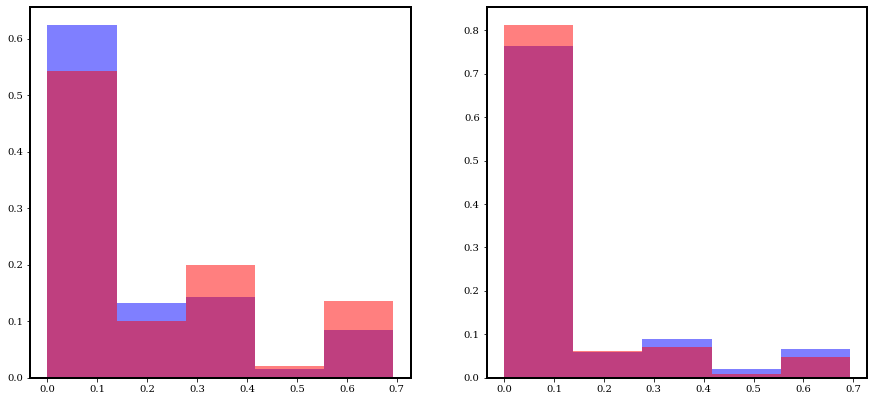

In [74]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

In [75]:
# add to dict
risk_scores_dict['agarwal_indep'] = risk_scores

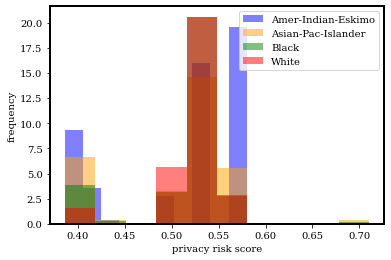

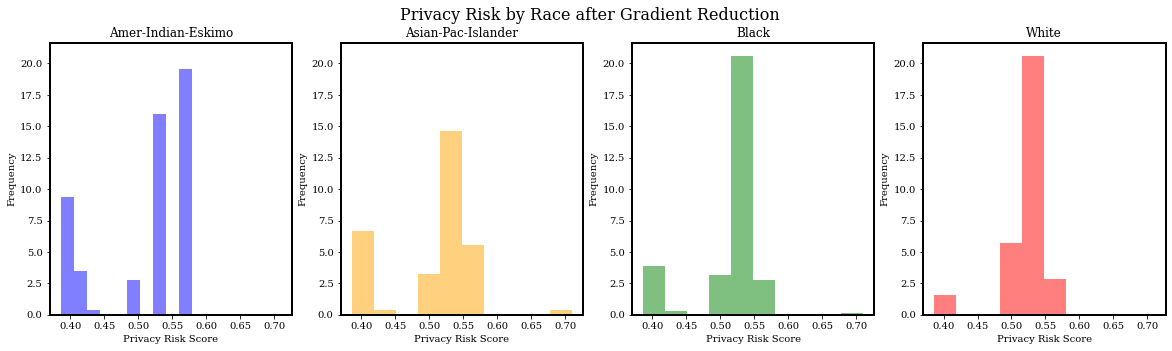

In [76]:
#risk_hist(map_race, 'race', ad_df_train, risk_scores)
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race after Gradient Reduction'
risk_hist(map_race, 'race', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race, 'race', ad_df_train, risk_scores, 1, 4, (20, 5), colors, title)

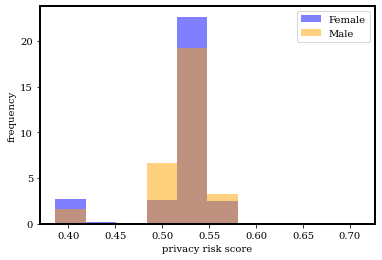

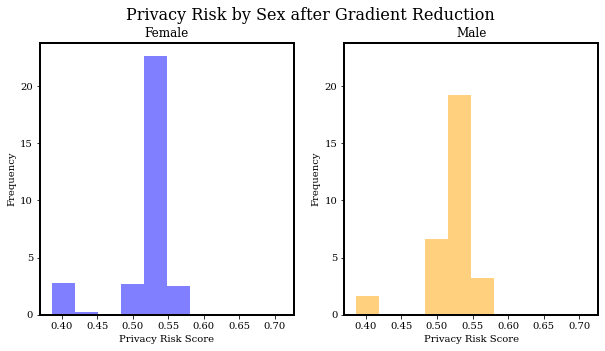

In [77]:
#risk_hist(map_sex, 'sex', ad_df_train, risk_scores)
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex after Gradient Reduction'
risk_hist(map_sex, 'sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_sex, 'sex', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

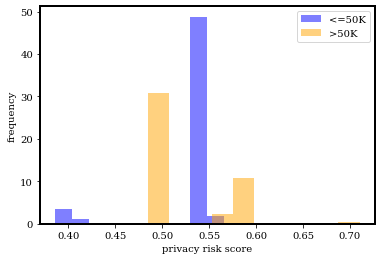

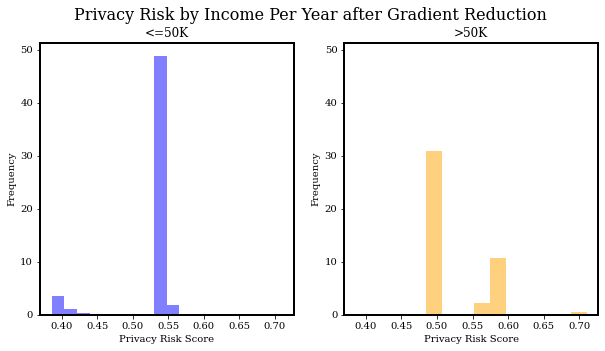

In [78]:
#risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)
colors = ['blue', 'orange']
title = 'Privacy Risk by Income Per Year after Gradient Reduction'
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_income, 'income-per-year', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

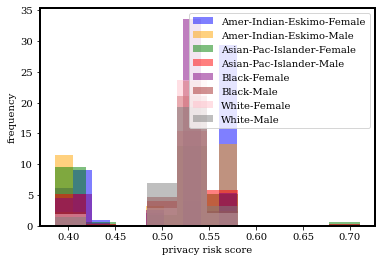

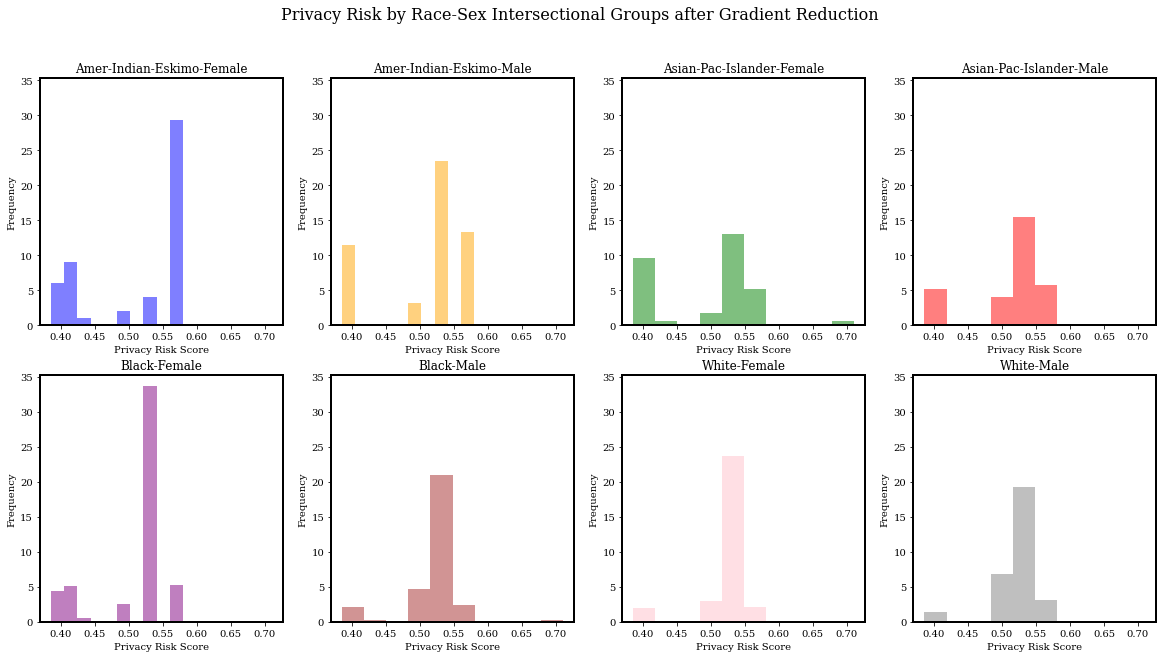

In [79]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups after Gradient Reduction'
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race_sex, 'race-sex', ad_df_train, risk_scores, 2, 4, (20, 10), colors, title)

# Equalized Odds (Separation)

## Hardt et al. (Postprocessing)

In [80]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

In [81]:
postprocessing = EqOddsPostprocessing(u, p)

In [82]:
postprocessing = postprocessing.fit(ad_train, ad_pred_train)
postprocess_pred = postprocessing.predict(ad_pred)

In [83]:
metrics_post = ClassificationMetric(ad_test,postprocess_pred,unprivileged_groups=u, privileged_groups=p)
test_acc_post = metrics_post.accuracy()
DI_post = metrics_post.disparate_impact()
EO_ppost = metrics_post.average_abs_odds_difference()
print('Postprocessing Test Accuracy:', test_acc_post)
print('Postprocessing Demographic Parity ratio:', DI_post)
print('Postprocessing Average Absolute Odds diff:', EO_ppost)

Postprocessing Test Accuracy: 0.8140995656531907
Postprocessing Demographic Parity ratio: 0.6174765669542002
Postprocessing Average Absolute Odds diff: 0.007857657450268743


### Membership Inference Attack

In [84]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = postprocessing.predict(shadow_train)
true_pred_on_shadow_test = postprocessing.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [85]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [86]:
# TODO: probabilities from hardt postprocessing technique
shadow_out_train = clf.predict_proba(shadow_Xs_train)
shadow_out_test = clf.predict_proba(shadow_Xs_test)
true_model_train = clf.predict_proba(Xs_train)
true_model_test = clf.predict_proba(Xs_test)

In [87]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [88]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [89]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.481
For membership inference attack via confidence, group attr 1, the attack acc is 0.519
For membership inference attack via confidence, group attr 2, the attack acc is 0.516
For membership inference attack via confidence, group attr 3, the attack acc is 0.491
For membership inference attack via confidence, group attr 4, the attack acc is 0.512
For membership inference attack via confidence, group attr 5, the attack acc is 0.504
For membership inference attack via confidence, group attr 6, the attack acc is 0.499
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.501
For membership inference attack via entropy, group attr 0, the attack acc is 0.505
For membership inference attack via entropy

In [90]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [91]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.551
For membership inference attack via confidence, group attr 1, the attack acc is 0.581
For membership inference attack via confidence, group attr 2, the attack acc is 0.571
For membership inference attack via confidence, group attr 3, the attack acc is 0.534
For membership inference attack via confidence, group attr 4, the attack acc is 0.524
For membership inference attack via confidence, group attr 5, the attack acc is 0.518
For membership inference attack via confidence, group attr 6, the attack acc is 0.509
For membership inference attack via confidence, group attr 7, the attack acc is 0.504
For membership inference attack via confidence, the attack acc is 0.509
For membership inference attack via entropy, group attr 0, the attack acc is 0.560
For membership inference attack via entropy

In [92]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.02653179014848006
generalization gap for group 1: 0.09867048823883351
generalization gap for group 2: 0.17540731468109852
generalization gap for group 3: 0.002246638772167242
generalization gap for group 4: 0.017953527783204845
generalization gap for group 5: 0.00017322828103910615
generalization gap for group 6: 0.000798460180094579
generalization gap for group 7: 0.01122496554711061


### Privacy Risk Score Analysis

In [93]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


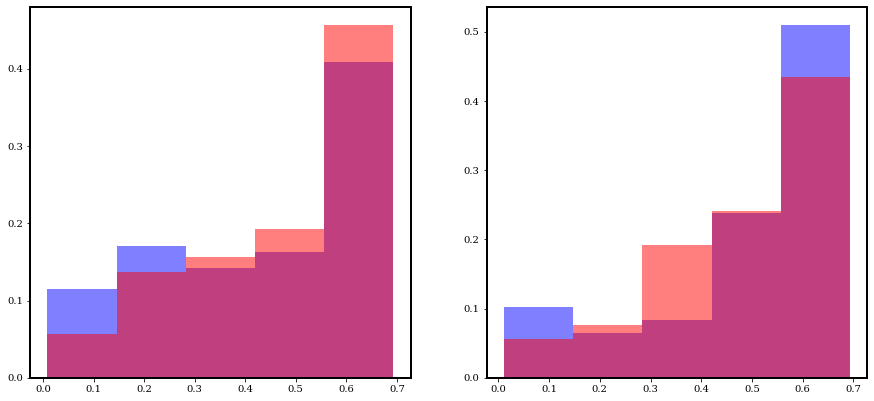

In [94]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

In [95]:
# add to dict
risk_scores_dict['hardt'] = risk_scores

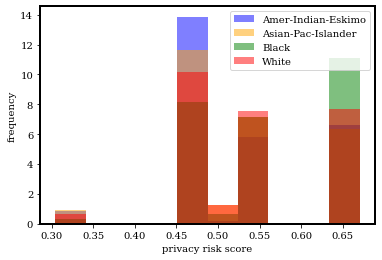

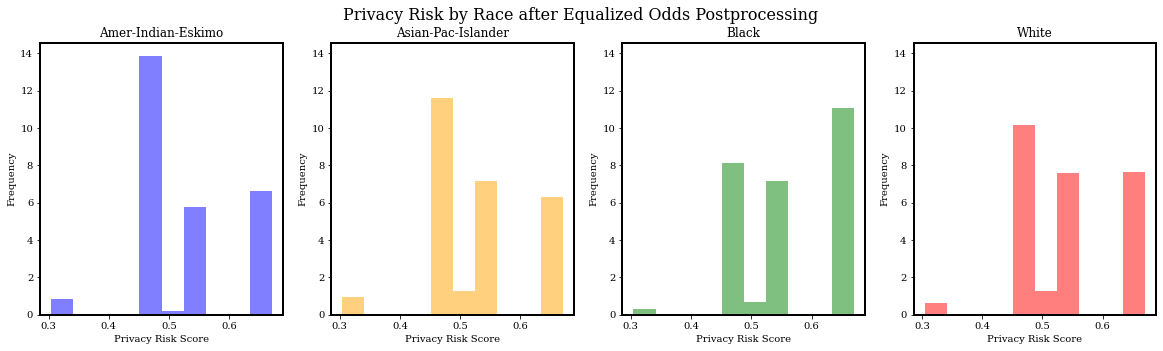

In [96]:
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race after Equalized Odds Postprocessing'
risk_hist(map_race, 'race', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race, 'race', ad_df_train, risk_scores, 1, 4, (20, 5), colors, title)

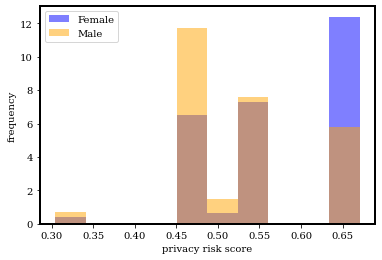

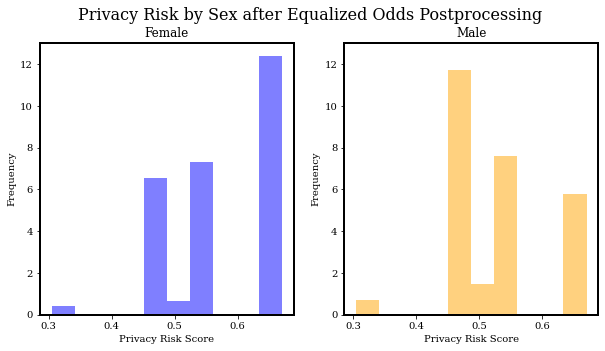

In [97]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex after Equalized Odds Postprocessing'
risk_hist(map_sex, 'sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_sex, 'sex', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

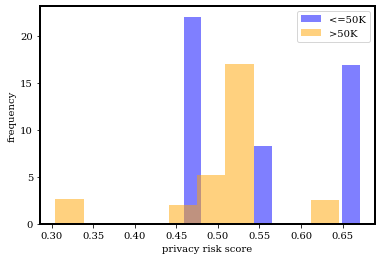

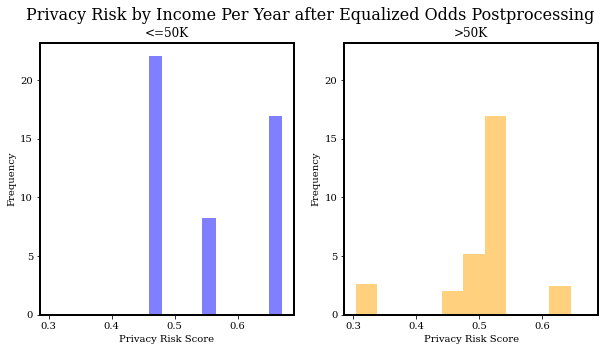

In [98]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Income Per Year after Equalized Odds Postprocessing'
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_income, 'income-per-year', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

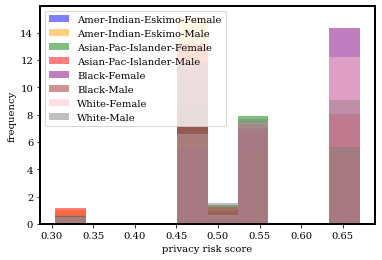

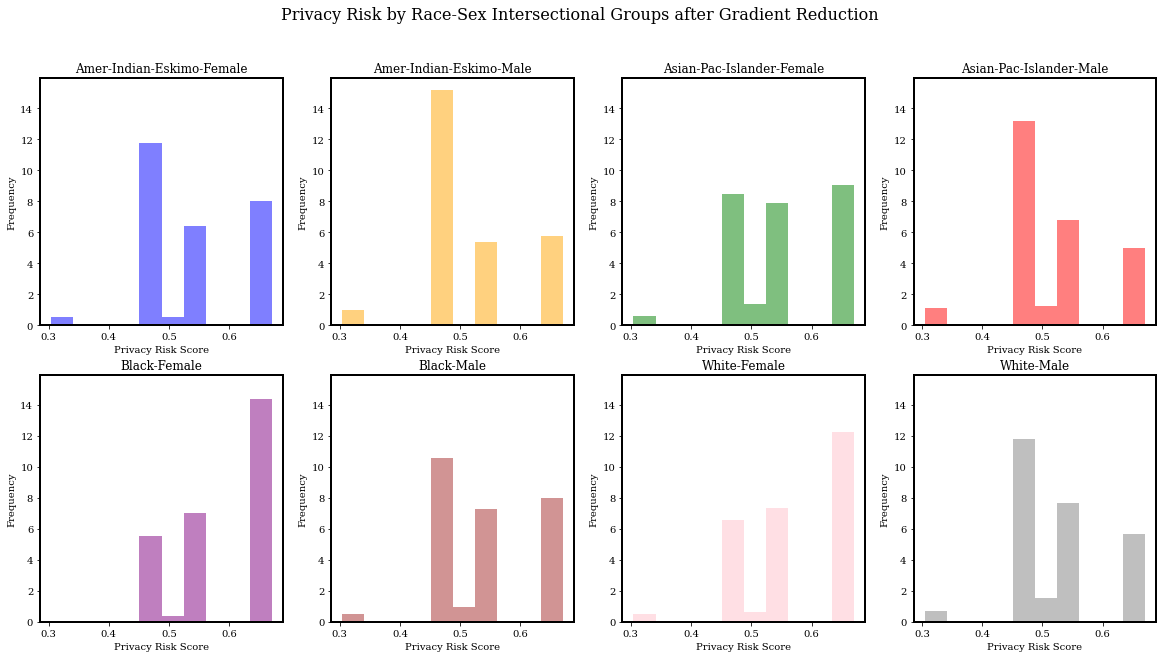

In [99]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups after Gradient Reduction'
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race_sex, 'race-sex', ad_df_train, risk_scores, 2, 4, (20, 10), colors, title)

## Agarwal et al (Reduction)

In [100]:
estimator = LogisticRegression(solver='liblinear')
#np.random.seed(0) 
#need for reproducibility
exp_grad_red = ExponentiatedGradientReduction(estimator=estimator, 
                                              constraints="EqualizedOdds",
                                              drop_prot_attr=False)

In [101]:
exp_grad_red.fit(ad_train)
exp_grad_red_pred = exp_grad_red.predict(ad_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [102]:
metrics_red_eo = ClassificationMetric(ad_test,exp_grad_red_pred,unprivileged_groups=u, privileged_groups=p)
test_acc_red_eo = metrics_red_eo.accuracy()
DI_red_eo = metrics_red_eo.disparate_impact()
EO_red_eo = metrics_red_eo.average_abs_odds_difference()
print('EO Reduction Test Accuracy:', test_acc_red_eo)
print('EO Reduction Demographic Parity ratio:', DI_red_eo)
print('EO Reduction Average Absolute Odds diff:', EO_red_eo)

EO Reduction Test Accuracy: 0.8036084196458403
EO Reduction Demographic Parity ratio: 0.5597276770243733
EO Reduction Average Absolute Odds diff: 0.013445095913619622


### Membership Inference Attack

In [103]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = exp_grad_red.predict(shadow_train)
true_pred_on_shadow_test = exp_grad_red.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [104]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [105]:
shadow_out_train = exp_grad_red.model.predict_proba(shadow_Xs_train)
shadow_out_test = exp_grad_red.model.predict_proba(shadow_Xs_test)
true_model_train = exp_grad_red.model.predict_proba(Xs_train)
true_model_test = exp_grad_red.model.predict_proba(Xs_test)

In [106]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [107]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [108]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.837 and test acc 0.836
For membership inference attack via confidence, group attr 0, the attack acc is 0.511
For membership inference attack via confidence, group attr 1, the attack acc is 0.515
For membership inference attack via confidence, group attr 2, the attack acc is 0.511
For membership inference attack via confidence, group attr 3, the attack acc is 0.546
For membership inference attack via confidence, group attr 4, the attack acc is 0.500
For membership inference attack via confidence, group attr 5, the attack acc is 0.510
For membership inference attack via confidence, group attr 6, the attack acc is 0.506
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.503
For membership inference attack via entropy, group attr 0, the attack acc is 0.559
For membership inference attack via entropy

In [109]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [110]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.837 and test acc 0.836
For membership inference attack via confidence, group attr 0, the attack acc is 0.613
For membership inference attack via confidence, group attr 1, the attack acc is 0.552
For membership inference attack via confidence, group attr 2, the attack acc is 0.558
For membership inference attack via confidence, group attr 3, the attack acc is 0.555
For membership inference attack via confidence, group attr 4, the attack acc is 0.518
For membership inference attack via confidence, group attr 5, the attack acc is 0.516
For membership inference attack via confidence, group attr 6, the attack acc is 0.508
For membership inference attack via confidence, group attr 7, the attack acc is 0.503
For membership inference attack via confidence, the attack acc is 0.509
For membership inference attack via entropy, group attr 0, the attack acc is 0.615
For membership inference attack via entropy

In [111]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.04184780251109027
generalization gap for group 1: 0.7769194535265487
generalization gap for group 2: 0.026615293655645744
generalization gap for group 3: 0.8966360012856049
generalization gap for group 4: 0.0009003717144848156
generalization gap for group 5: 0.4872392853519729
generalization gap for group 6: 0.05060965438265019
generalization gap for group 7: 0.01190474578450873


### Privacy Risk Score Analysis

In [112]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


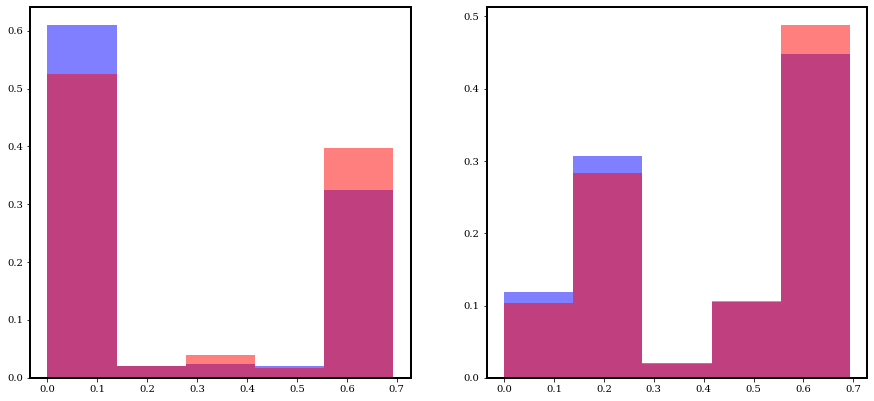

In [113]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

In [114]:
# add to dict
risk_scores_dict['agarwal_sep'] = risk_scores

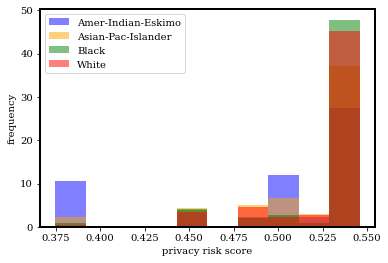

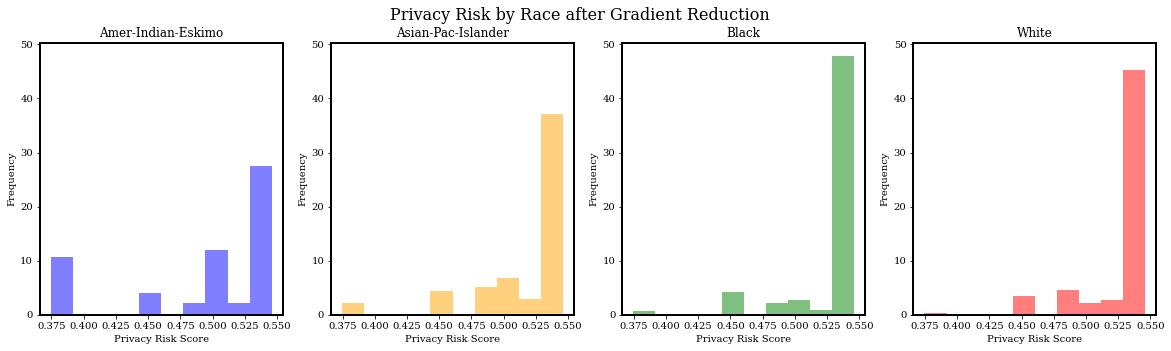

In [115]:
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race after Gradient Reduction'
risk_hist(map_race, 'race', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race, 'race', ad_df_train, risk_scores, 1, 4, (20, 5), colors, title)

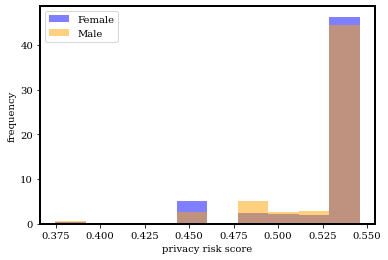

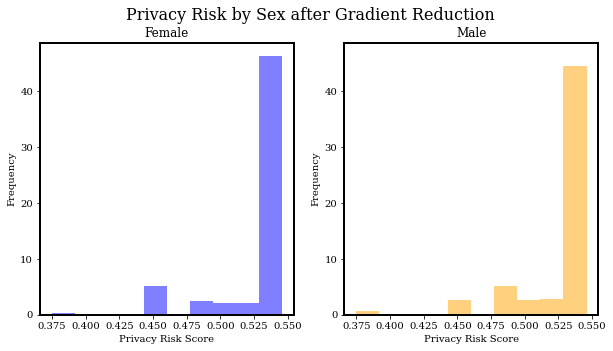

In [116]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex after Gradient Reduction'
risk_hist(map_sex, 'sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_sex, 'sex', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

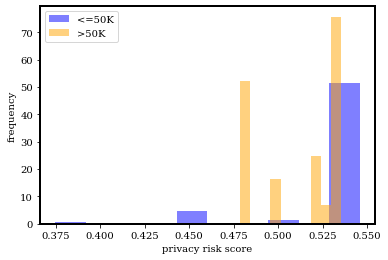

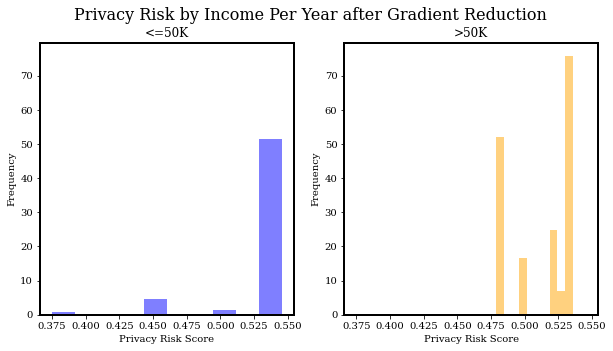

In [117]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Income Per Year after Gradient Reduction'
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_income, 'income-per-year', ad_df_train, risk_scores, 1, 2, (10, 5), colors, title)

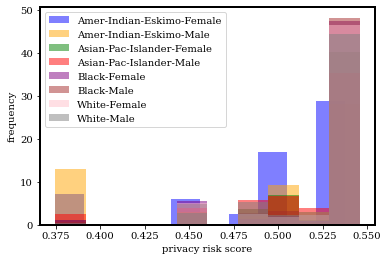

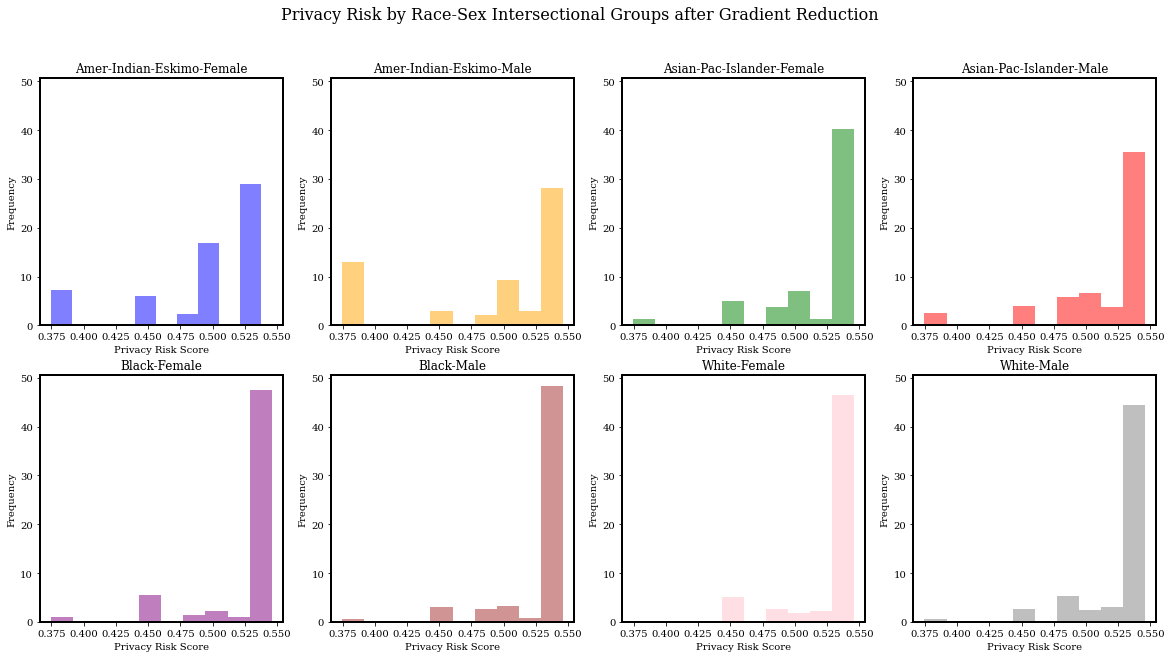

In [118]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups after Gradient Reduction'
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores, colors)
risk_hist_subplots(map_race_sex, 'race-sex', ad_df_train, risk_scores, 2, 4, (20, 10), colors, title)

In [282]:
def risk_hist_subplots_all(attr_map, attr_name, ad_df_train, risk_scores_dict, ht, wdth, figsize, colors, ylabel_map, title_map, title):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(ht, wdth, hspace=0.08, wspace=0)
    axs = gs.subplots(sharey = True, sharex = True)
    for j, interv in enumerate(risk_scores_dict):
        risk_scores = risk_scores_dict[interv]
        for i, attr in enumerate(attr_map):
            idx = ad_df_train[attr_name] == attr
            axs[i, j].hist(risk_scores[idx], label=attr_map[attr], density=True, color=colors[i], alpha=0.5)
            if j == 0:
                axs[i, j].set_ylabel(ylabel_map[attr_map[i]],fontsize=14)
            if i == 0:
                axs[i, j].set_title(title_map[interv], fontsize=14)
    fig.suptitle(title, fontsize=20)
    fig.supxlabel('Privacy Risk Score', fontsize=18)
    fig.supylabel('Frequency', fontsize=18)

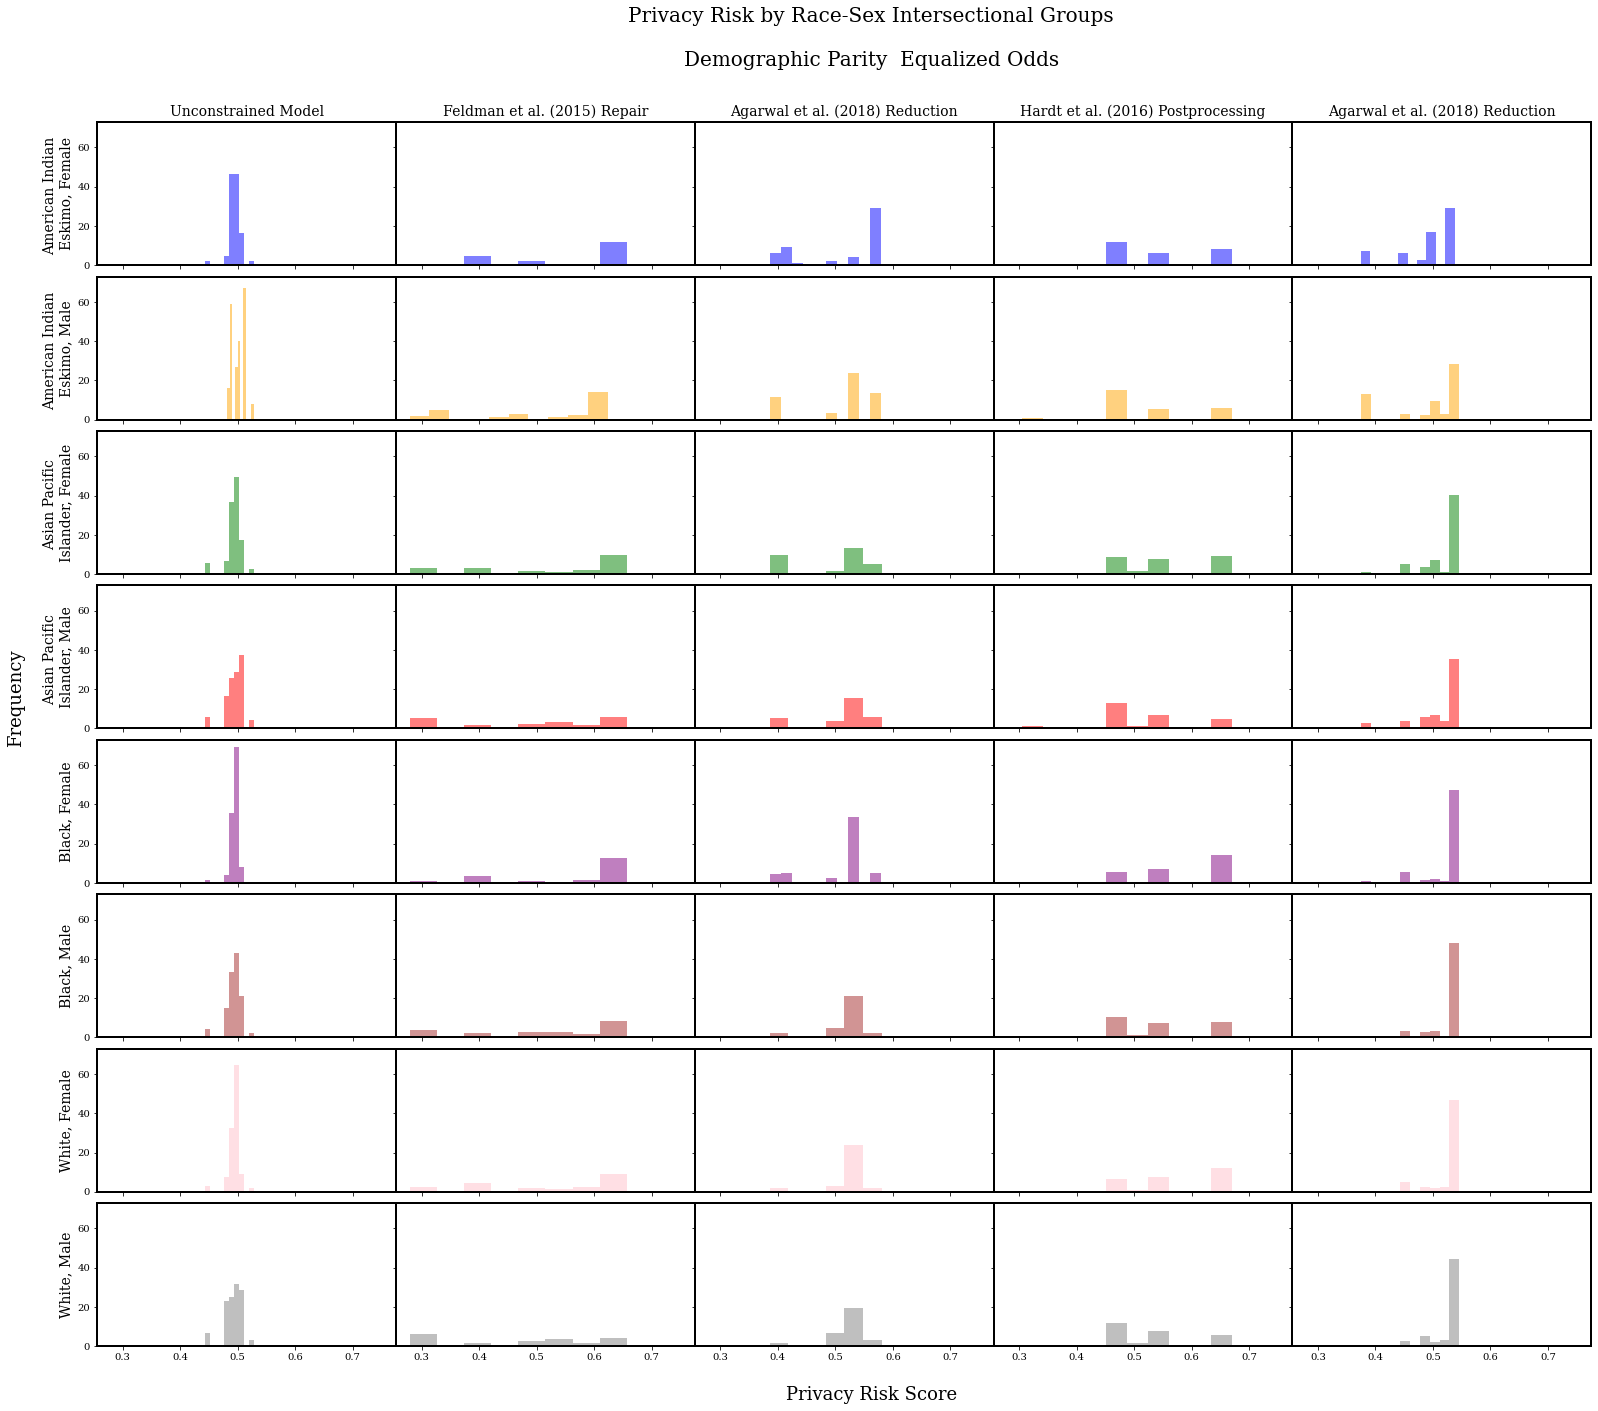

In [285]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
title = 'Privacy Risk by Race-Sex Intersectional Groups\n\nDemographic Parity  Equalized Odds'

title_map = {'unconstrained': 'Unconstrained Model', 
             'feldman': 'Feldman et al. (2015) Repair', 
             'agarwal_indep': 'Agarwal et al. (2018) Reduction', 
             'hardt': 'Hardt et al. (2016) Postprocessing', 
             'agarwal_sep': 'Agarwal et al. (2018) Reduction'}

ylabel_map = {'Amer-Indian-Eskimo-Female': 'American Indian \nEskimo, Female', 
              'Amer-Indian-Eskimo-Male': 'American Indian \nEskimo, Male', 
              'Asian-Pac-Islander-Female': 'Asian Pacific \nIslander, Female', 
              'Asian-Pac-Islander-Male': 'Asian Pacific \nIslander, Male', 
              'Black-Female': 'Black, Female',
              'Black-Male': 'Black, Male', 
              'White-Female': 'White, Female', 
              'White-Male': 'White, Male'}
risk_hist_subplots_all(map_race_sex, 'race-sex', ad_df_train, risk_scores_dict, 8, 5, (25, 20), colors, ylabel_map, title_map, title)
plt.subplots_adjust(top=0.9, bottom=0.05, left=0.07)

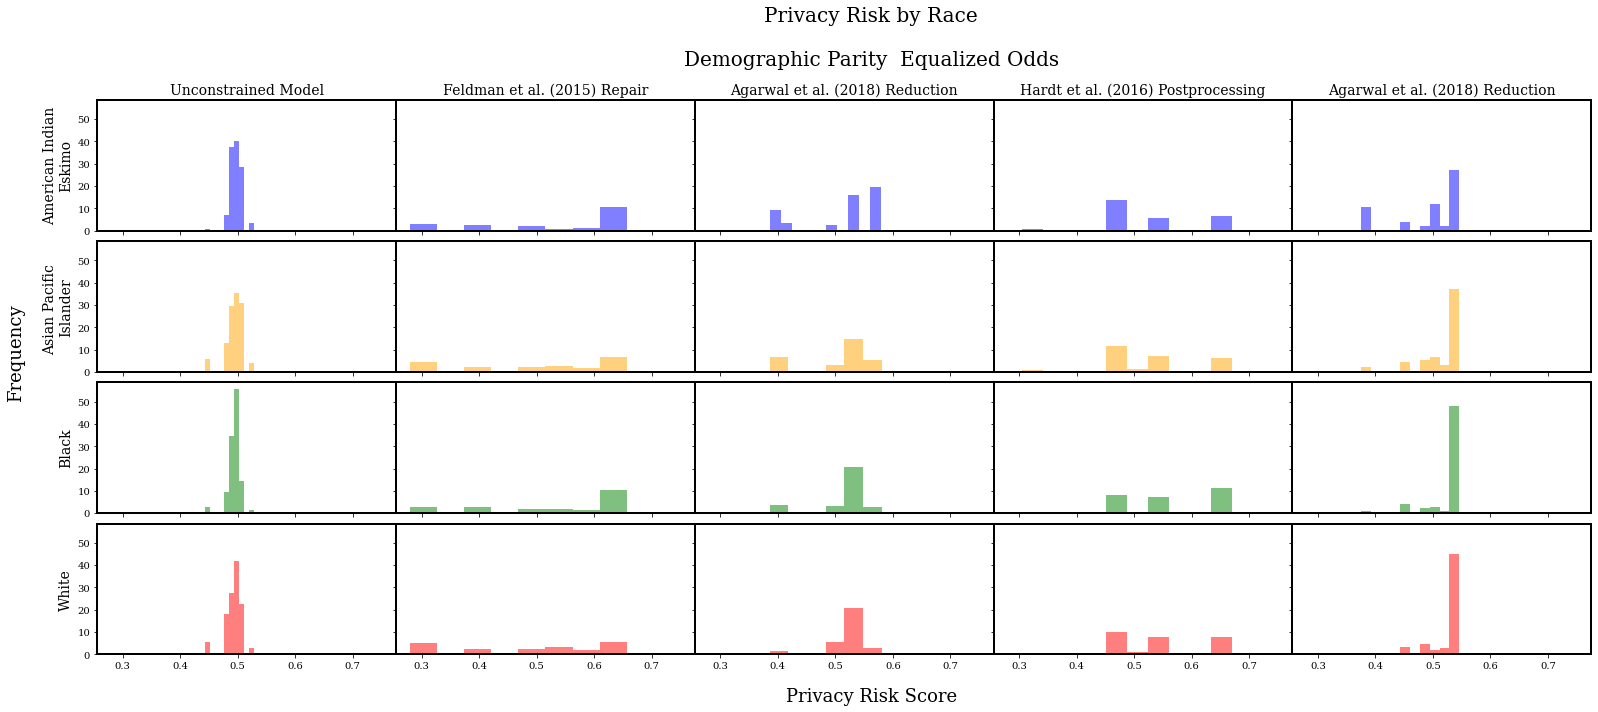

In [286]:
colors = ['blue', 'orange', 'green', 'red']
title = 'Privacy Risk by Race\n\nDemographic Parity  Equalized Odds'
ylabel_map = {'Amer-Indian-Eskimo': 'American Indian\nEskimo',
              'Asian-Pac-Islander': 'Asian Pacific \nIslander', 
              'Black': 'Black',
              'White': 'White'}
risk_hist_subplots_all(map_race, 'race', ad_df_train, risk_scores_dict, 4, 5, (25, 10), colors, ylabel_map, title_map, title)
plt.subplots_adjust(top=0.85, bottom=0.08, left=0.07)

In [320]:
def risk_hist_subplots_sex(attr_map, attr_name, ad_df_train, risk_scores_dict, ht, wdth, figsize, colors, ylabel_map, title_map, title):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(ht, wdth, hspace=0.08, wspace=0)
    axs = gs.subplots(sharey = True, sharex = True)
    for i, interv in enumerate(risk_scores_dict):
        risk_scores = risk_scores_dict[interv]
        for j, attr in enumerate(attr_map):
            idx = ad_df_train[attr_name] == attr
            axs[i].hist(risk_scores[idx], label=attr_map[attr], density=True, color=colors[j], alpha=0.5)
            axs[i].legend()
            axs[i].set_title(title_map[interv], fontsize=14)
    fig.suptitle(title, fontsize=20)
    fig.supxlabel('Privacy Risk Score', fontsize=18)
    fig.supylabel('Frequency', fontsize=18)

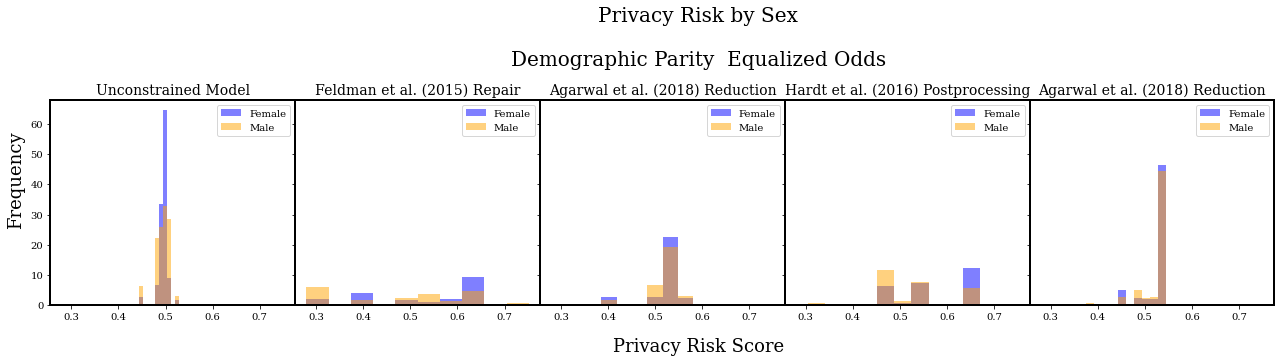

In [334]:
colors = ['blue', 'orange']
title = 'Privacy Risk by Sex\n\nDemographic Parity  Equalized Odds'
ylabel_map = {'Female': 'Female', 
              'Male': 'Male'}
risk_hist_subplots_sex(map_sex, 'sex', ad_df_train, risk_scores_dict, 1, 5, (20, 5), colors, ylabel_map, title_map, title)
plt.subplots_adjust(top=0.72, bottom=0.15, left=0.05)